## **Packages to be installed during Runtime**

In [ ]:
pip install pyspark

     |████████████████████████████████| 212.3MB 67kB/s 
     |████████████████████████████████| 204kB 19.3MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.1-py2.py3-none-any.whl size=212767604 sha256=2dc19f016d252508a9a0c93651e46d42fe33f11f05ee7efe0f0c19273febc163
  Stored in directory: /root/.cache/pip/wheels/0b/90/c0/01de724414ef122bd05f056541fb6a0ecf47c7ca655f8b3c0f
Successfully built pyspark


## **Importing Necessary Libraries**

In [ ]:
#For the Spark Session
from pyspark.sql import SparkSession
from pyspark import SparkContext

#For Data Manipulation
from pyspark.mllib.regression import LabeledPoint
from pyspark.ml import linalg as ml_linalg
from pyspark.mllib.linalg import Vectors as MLLibVectors
import pandas as pd
import numpy as np

#For NLP
from pyspark.ml.feature import HashingTF,RegexTokenizer,StopWordsRemover
from pyspark.mllib.classification import SVMWithSGD

## **Creating a session and reading necessary files**

In [ ]:
sc = SparkContext();
spark = SparkSession.builder.appName('Sentiment Analysis').getOrCreate()
print("The default number of partitions are =",sc.defaultParallelism)

The default number of partitions are = 2


In [ ]:
#Creating a Spark dataframe from train & test data
train_df=spark.read.csv('train.csv',inferSchema=True,header=True)
test_df=spark.read.csv('test.csv',inferSchema=True,header=True)

In [ ]:
train_df.show(truncate=False)

+------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Labels|Sentences                                                                                                                                                    

In [ ]:
test_df.show(truncate=False)

+------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Labels|Sentences                                                                                                                                                      

In [ ]:
print("Length of train dataset =",train_df.count())
print("Length of test dataset =",train_df.count())

Length of train dataset = 98948
Length of test dataset = 98948


In [ ]:
print("Type of the train dataset =",type(train_df))
print("Type of the test dataset =",type(test_df))

Type of the train dataset = <class 'pyspark.sql.dataframe.DataFrame'>
Type of the test dataset = <class 'pyspark.sql.dataframe.DataFrame'>


## **Data Pre-Processing**



> **Train Dataset**



In [ ]:
#Tokenization
tok=RegexTokenizer()
tokenizer=RegexTokenizer(inputCol="Sentences",outputCol="Words")
tok_train=tokenizer.transform(train_df)

In [ ]:
#Removing stop-words
stopwords=StopWordsRemover()
stop_words_remover=StopWordsRemover(inputCol=tokenizer.getOutputCol(),outputCol="Important_Words")
stop_train=stop_words_remover.transform(tok_train)

In [ ]:
#Performing Hashing Term Frequency
hTF=HashingTF()
hashing_TF=HashingTF(inputCol=stop_words_remover.getOutputCol(),outputCol="Features")
hash_train=hashing_TF.transform(stop_train).select('Labels','Important_Words','Features')



> **Test Dataset**



In [ ]:
#Tokenization
tokenizer_test=RegexTokenizer(inputCol="Sentences",outputCol="Words")
tok_test=tokenizer_test.transform(test_df)

In [ ]:
#Removing stop-words
stop_words_r=StopWordsRemover(inputCol=tokenizer_test.getOutputCol(),outputCol="Important_Words")
stop_test=stop_words_r.transform(tok_test)

In [ ]:
#Performing Hashing Term Frequency
hash_test=HashingTF(inputCol=stop_words_r.getOutputCol(),outputCol="Features").transform(stop_test)

In [ ]:
#Final pre-processed train & test datasets
training=hash_train
testing=hash_test

In [ ]:
print("Type of the final train dataset =",type(training))
print("Type of the final test dataset =",type(testing))

Type of the final train dataset = <class 'pyspark.sql.dataframe.DataFrame'>
Type of the final test dataset = <class 'pyspark.sql.dataframe.DataFrame'>


## **Defining Important Functions**

In [ ]:
#Funtion to convert a Sparse and Dense vector to MLLIB format
def as_mllib(v):
    if isinstance(v, ml_linalg.SparseVector):
        return MLLibVectors.sparse(v.size, v.indices, v.values)
    elif isinstance(v, ml_linalg.DenseVector):
        return MLLibVectors.dense(v.toArray())
    else:
        raise TypeError("Unsupported type: {0}".format(type(v)))

## **Evaluating and Saving the model**

In [ ]:
#Converting the train dataset to LabeledPoint and training it
train_list  = training.rdd.map(lambda x: LabeledPoint(x["Labels"],as_mllib(x["Features"]))).collect()
SVM_model=SVMWithSGD.train(sc.parallelize(train_list))

In [ ]:
print(type(train_list))

<class 'list'>


In [ ]:
#Converting the test dataset to LabeledPoint and performing parallel computation
test_list=testing.rdd.map(lambda x: LabeledPoint(x["Labels"],as_mllib(x["Features"]))).collect()

test_parallelize=sc.parallelize(test_list)
test=spark.createDataFrame(test_parallelize)
test.show(truncate=True)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(262144,[3370,218...|  1.0|
|(262144,[3421,694...|  1.0|
|(262144,[1578,576...|  0.0|
|(262144,[3190,720...|  1.0|
|(262144,[20575,28...|  1.0|
|(262144,[2325,553...|  0.0|
|(262144,[11941,19...|  0.0|
|(262144,[5000,101...|  0.0|
|(262144,[17792,40...|  1.0|
|(262144,[80702,13...|  0.0|
|(262144,[1817,219...|  1.0|
|(262144,[4500,414...|  0.0|
|(262144,[8169,161...|  0.0|
|(262144,[3228,383...|  1.0|
|(262144,[40921,50...|  0.0|
|(262144,[3445,612...|  0.0|
|(262144,[23087,26...|  1.0|
|(262144,[20263,46...|  1.0|
|(262144,[31135,32...|  1.0|
|(262144,[60844,61...|  1.0|
+--------------------+-----+
only showing top 20 rows



In [ ]:
print(type(test_list))
print(type(test))

<class 'list'>
<class 'pyspark.sql.dataframe.DataFrame'>


In [ ]:
#Predicting values on the test dataset and performing parallel computation
SVM_prediction_and_labels = test.rdd.map(lambda p:(p.label,SVM_model.predict(p.features))).collect()

SVM_Pal_Parallelize=sc.parallelize(SVM_prediction_and_labels)
c=["Labels","Prediction"]
pal=spark.createDataFrame(SVM_Pal_Parallelize,c)
pal.show()

+------+----------+
|Labels|Prediction|
+------+----------+
|   1.0|         1|
|   1.0|         1|
|   0.0|         0|
|   1.0|         1|
|   1.0|         1|
|   0.0|         0|
|   0.0|         0|
|   0.0|         0|
|   1.0|         1|
|   0.0|         0|
|   1.0|         1|
|   0.0|         1|
|   0.0|         0|
|   1.0|         1|
|   0.0|         0|
|   0.0|         0|
|   1.0|         1|
|   1.0|         1|
|   1.0|         1|
|   1.0|         1|
+------+----------+
only showing top 20 rows



In [ ]:
print(type(SVM_prediction_and_labels))
print(pal)

<class 'list'>
DataFrame[Labels: double, Prediction: bigint]


**In the two cells above, we first compute the needful and then convert it to a Spark Dataframe. We do this because, once we apply map, the dataset gets converted to a list and no operations can be performed on a list.**

In [ ]:
#Computing the accuracy of the model
SVM_correct = pal.rdd.filter(lambda p: p['Labels'] == p['Prediction'])
SVM_accuracy = (SVM_correct.count() / float(testing.count()))*100
print("The accuracy of SVM is =",round(SVM_accuracy,2),"%")

The accuracy of SVM is = 78.15 %




> Before running the next cell - **Mount Google Drive**. To do so, open the Files section in the left hand side of this interface and click on the third icon. 

***Third icon in the picture given below***

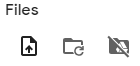

In [ ]:
#Saving all the vectorizers and the model
tok.save("tokenizer")
stopwords.save("stop_words")
hTF.save("vec")
SVM_model.save(sc,'svm_model')

In [ ]:
#hello

##**Thank You!**